In [1]:
#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# essentials
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# all the sklearn stuff
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler    

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from tqdm.autonotebook import tqdm

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, hamming_loss, zero_one_loss

Source for multiclass neural net classifier:

https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

Source for cost sensitive loss function:

https://github.com/agaldran/cost_sensitive_loss_classification

In [2]:
seed = 42

# Training data.
df = pd.read_pickle("data.pkl")
df

,pianist_id,segment_id,snippet_id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,...,gems_peacefulness_binary,gems_power_binary,gems_joyful_activation_binary,gems_tension_binary,gems_sadness_binary,gemmes_movement_binary,gemmes_force_binary,gemmes_interior_binary,gemmes_wandering_binary,gemmes_flow_binary
0,1,0,0,0.192237,0.059404,2.040252,16079768.0,0.800000,0.677256,0.095846,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1,0,1,0.143425,0.064204,3.138845,35489248.0,2.600000,0.514913,0.092372,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1,0,2,0.146967,0.056205,2.019706,42130144.0,2.600000,0.560116,0.115359,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1,0,3,0.158810,0.059129,3.567908,40922732.0,1.400000,0.596779,0.116061,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1,0,4,0.168547,0.049648,2.329854,51921612.0,1.600000,0.556160,0.143420,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,11,26,2,0.202177,0.050760,2.840705,51977460.0,1.800000,0.688834,0.090235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4176,11,26,3,0.174454,0.063426,5.202462,9471357.0,3.200000,0.661253,0.107627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4177,11,26,4,0.161152,0.074724,4.605277,7378860.5,2.600000,0.645111,0.093705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4178,11,26,5,0.192846,0.056795,2.563405,22641664.0,3.200000,0.680604,0.094989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<AxesSubplot:xlabel='quadrant', ylabel='count'>

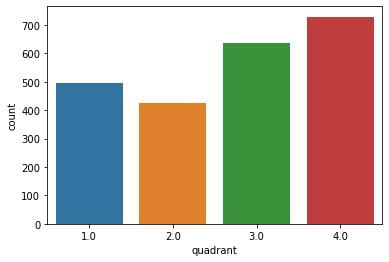

In [3]:
sns.countplot(x = 'quadrant', data=df)

In [4]:
class2idx = {
    1:0,
    2:1,
    3:2,
    4:3}

idx2class = {v: k for k, v in class2idx.items()}

df['quadrant'].replace(class2idx, inplace=True)

<AxesSubplot:xlabel='quadrant', ylabel='count'>

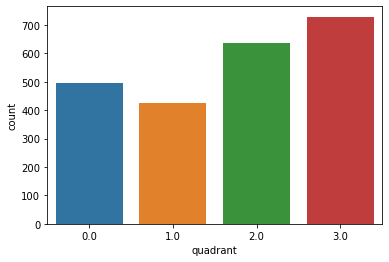

In [5]:
"""labels = df["valence"].to_numpy().flatten()"""
labels = df["quadrant"].values
labels
sns.countplot(x = 'quadrant', data=df)

In [6]:
df = df.drop(columns=[
    'librosa_chroma_pct_50_1',  #keep just the most representative amonst the highly correlated
    'librosa_chroma_pct_50_3', 
    'librosa_chroma_pct_50_4', 
    'librosa_chroma_pct_50_6', 
    'librosa_chroma_pct_50_8', 
    'librosa_chroma_pct_50_9', 
    'librosa_chroma_pct_50_10', 
    # 'librosa_chroma_pct_50_11', 
    'librosa_mfcc_pct_10_0', 
    'librosa_mfcc_pct_50_0', 
    'librosa_mfcc_pct_90_0', 
    'librosa_mfcc_pct_50_1', 
    'librosa_mfcc_pct_10_2', 
    'librosa_mfcc_pct_50_2', 
    'librosa_mfcc_pct_90_2', 
    'librosa_mfcc_pct_50_3', 
    'librosa_mfcc_pct_50_4', 
    'librosa_mfcc_pct_50_5', 
    'librosa_mfcc_pct_50_6', 
    'librosa_mfcc_pct_50_7', 
    'librosa_mfcc_pct_50_8', 
    'librosa_mfcc_pct_50_9', 
    'librosa_mfcc_pct_50_10', 
    #'librosa_mfcc_pct_50_11', 
    'mirtoolbox_dynamics_pct_10', 
    'mirtoolbox_dynamics_pct_50', 
    #'mirtoolbox_dynamics_pct_90', 
    'mirtoolbox_novelty_pct_90', 
    'mirtoolbox_roughness_pct_50', 
    #'mirtoolbox_roughness_pct_90',

    'pianist_id', 'segment_id', 'snippet_id',

    "gems_wonder_binary",
    "gems_transcendence_binary",
    "gems_tenderness_binary",
    "gems_nostalgia_binary",
    "gems_peacefulness_binary",
    "gems_power_binary",
    "gems_joyful_activation_binary",
    "gems_tension_binary",
    "gems_sadness_binary",
    "gemmes_movement_binary",
    "gemmes_force_binary",
    "gemmes_interior_binary",
    "gemmes_wandering_binary",
    "gemmes_flow_binary",
    "gemmes_flow",
                    
    'gemmes_movement',
    'gemmes_force',
    'gemmes_wandering',
    'gems_sadness',
    'gems_tension',
    'gems_joyful_activation',
    'gems_transcendence',
    'gems_power',
    'gems_nostalgia',
    'gems_wonder',
    'gems_tenderness',
    'gemmes_interior',
    'gems_peacefulness',
    
    'quadrant', 
    'arousal',
    'valence'
])
df

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,...,mirtoolbox_mode,mirtoolbox_novelty_mean,mirtoolbox_novelty_std,mirtoolbox_novelty_pct_10,mirtoolbox_novelty_pct_50,mirtoolbox_pulseclarity,mirtoolbox_roughness_mean,mirtoolbox_roughness_std,mirtoolbox_roughness_pct_10,mirtoolbox_roughness_pct_90
0,0.192237,0.059404,2.040252,16079768.0,0.800000,0.677256,0.095846,1290.972900,936.912476,30.490740,...,-0.092027,0.041443,0.106446,0.00000,0.013819,0.169743,0.011449,0.004161,0.006684,0.017025
1,0.143425,0.064204,3.138845,35489248.0,2.600000,0.514913,0.092372,1133.526733,286.292847,28.111111,...,-0.153564,0.113378,0.193342,0.00000,0.027786,0.355861,0.006205,0.003194,0.002583,0.010610
2,0.146967,0.056205,2.019706,42130144.0,2.600000,0.560116,0.115359,1050.947632,181.327225,28.354166,...,-0.002827,0.143144,0.218179,0.00000,0.049050,0.209162,0.007467,0.003986,0.002330,0.012690
3,0.158810,0.059129,3.567908,40922732.0,1.400000,0.596779,0.116061,1076.780151,251.776215,29.354166,...,-0.083029,0.053186,0.118148,0.00002,0.017653,0.232454,0.007335,0.004063,0.002609,0.012971
4,0.168547,0.049648,2.329854,51921612.0,1.600000,0.556160,0.143420,1008.112183,196.336700,29.375000,...,-0.172612,0.063815,0.121018,0.00000,0.020525,0.140930,0.007345,0.003917,0.002662,0.012731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,0.202177,0.050760,2.840705,51977460.0,1.800000,0.688834,0.090235,866.423889,133.063477,29.842592,...,-0.042110,0.145387,0.203668,0.00000,0.052074,0.269012,0.014044,0.004991,0.007948,0.020522
4176,0.174454,0.063426,5.202462,9471357.0,3.200000,0.661253,0.107627,828.768005,234.908127,30.296297,...,-0.290169,0.091809,0.161435,0.00000,0.029478,0.353269,0.011126,0.004529,0.005563,0.016763
4177,0.161152,0.074724,4.605277,7378860.5,2.600000,0.645111,0.093705,841.285645,226.538666,29.761574,...,-0.254077,0.065565,0.130765,0.00000,0.025099,0.319188,0.009205,0.004808,0.004193,0.016254
4178,0.192846,0.056795,2.563405,22641664.0,3.200000,0.680604,0.094989,716.426025,181.553772,29.881945,...,-0.079091,0.188159,0.247554,0.00000,0.084562,0.133573,0.013538,0.004881,0.007919,0.019997


In [7]:
X = df
y = labels

In [8]:
np.random.seed(seed)

# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=seed)

In [9]:
np.random.seed(seed)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
def get_class_distribution(obj):
    count_dict = {
        'happy': 0,
        'angry': 0,
        'sad': 0,
        'relaxed': 0}
    
    for i in obj:
        if i == 0: 
            count_dict['happy'] += 1
        elif i == 1: 
            count_dict['angry'] += 1
        elif i == 2: 
            count_dict['sad'] += 1
        elif i == 3: 
            count_dict['relaxed'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

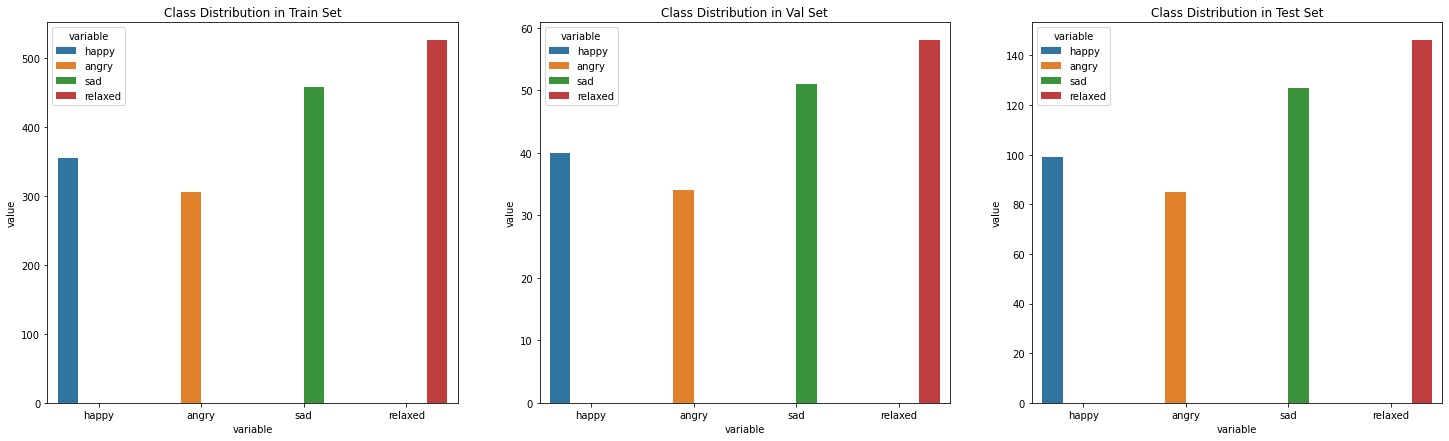

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [12]:
np.random.seed(seed)

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [13]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [14]:
np.random.seed(seed)

class_count = [i for i in get_class_distribution(y_train).values()]#

class_weights = 1./torch.tensor(class_count, dtype=torch.float)

# bias cost of (mis)classification
#class_weights[1] *= 2
#class_weights[2] *= 2

print(class_weights) 

# only class count imbalance bias:                      tensor([0.0028, 0.0033, 0.0022, 0.0019])
# both class count imbalance bias and gain matrix bias: tensor([0.0028, 0.0066, 0.0044, 0.0019])

tensor([0.0028, 0.0033, 0.0022, 0.0019])


In [15]:
class_weights_all = class_weights[target_list]

In [16]:
np.random.seed(seed)

weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [17]:
EPOCHS = 1000
BATCH_SIZE = 5
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 4

In [36]:
M = np.array([[  5, -5, -5,  2],
              [ -5, 10,  2, -5],
              [ -5,  2, 10, -5],
              [  2, -5, -2,  5]], dtype=float)
M += 5
M = M / np.linalg.norm(M)
"""M = 1 - M"""
M

array([[0.34199278, 0.        , 0.        , 0.23939495],
       [0.        , 0.51298918, 0.23939495, 0.        ],
       [0.        , 0.23939495, 0.51298918, 0.        ],
       [0.23939495, 0.        , 0.10259784, 0.34199278]])

In [19]:
def cost_sensitive_loss(input, target, M):
    if input.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(input.size(0), target.size(0)))
    device = input.device
    M = M.to(device)
    return (M[target, :]*input.float()).sum(axis=-1)
    # return torch.diag(torch.matmul(input, M[:, target]))

class CostSensitiveLoss(nn.Module):
    def __init__(self,  NUM_CLASSES, exp=1, normalization='softmax', reduction='mean'):
        super(CostSensitiveLoss, self).__init__()
        if normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        elif normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = None
        self.reduction = reduction
        x = np.abs(np.arange(NUM_CLASSES, dtype=np.float32))
        M = np.abs((x[:, np.newaxis] - x[np.newaxis, :])) ** exp
        M /= M.max()
        self.M = torch.from_numpy(M)

    def forward(self, logits, target):
        preds = self.normalization(logits)
        loss = cost_sensitive_loss(preds, target, self.M)
        if self.reduction == 'none':
            return loss
        elif self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            raise ValueError('`reduction` must be one of \'none\', \'mean\', or \'sum\'.')

class CostSensitiveRegularizedLoss(nn.Module):
    def __init__(self,  n_classes=NUM_CLASSES, exp=2, normalization='softmax', reduction='mean', base_loss='ce', lambd=10):
        super(CostSensitiveRegularizedLoss, self).__init__()
        if normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        elif normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = None
        self.reduction = reduction
        x = np.abs(np.arange(n_classes, dtype=np.float32))
        M = np.abs((x[:, np.newaxis] - x[np.newaxis, :])) ** exp
        #
        # M_oph = np.array([
        #                 [1469, 4, 5,  0,  0],
        #                 [58, 62,  5,  0,  0],
        #                 [22, 3, 118,  1,  0],
        #                 [0, 0,   13, 36,  1],
        #                 [0, 0,    0,  1, 15]
        #                 ], dtype=np.float)
        # M_oph = M_oph.T
        # # Normalize M_oph to obtain M_difficulty:
        # M_difficulty = 1-np.divide(M_oph, np.sum(M_oph, axis=1)[:, None])
        # # OPTION 1: average M and M_difficulty:
        # M = 0.5 * M + 0.5 * M_difficulty
        # ################
        # # OPTION 2: replace uninformative entries in M_difficulty by entries of M:
        # # M_difficulty[M_oph == 0] = M[M_oph == 0]
        # # M = M_difficulty

        M /= M.max()
        self.M = torch.from_numpy(M)
        self.lambd = lambd
        self.base_loss = base_loss

        if self.base_loss == 'ce':
            self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        elif self.base_loss == 'ls':
            self.base_loss = label_smoothing_criterion(distribution='uniform', reduction=reduction)
        elif self.base_loss == 'gls':
            self.base_loss = label_smoothing_criterion(distribution='gaussian', reduction=reduction)
        elif self.base_loss == 'focal_loss':
            kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": reduction}
            self.base_loss = focal_loss(**kwargs)
        else:
            sys.exit('not a supported base_loss')

    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        if self.lambd == 0:
            return self.base_loss(logits, target)
        else:
            preds = self.normalization(logits)
            loss = cost_sensitive_loss(preds, target, self.M)
            if self.reduction == 'none':
                return base_l + self.lambd*loss
            elif self.reduction == 'mean':
                return base_l + self.lambd*loss.mean()
            elif self.reduction == 'sum':
                return base_l + self.lambd*loss.sum()
            else:
                raise ValueError('`reduction` must be one of \'none\', \'mean\', or \'sum\'.')
                
base_loss = 'ce'
lambd = 10
cs_regularized_criterion = CostSensitiveRegularizedLoss(n_classes=NUM_CLASSES, base_loss=base_loss, lambd=lambd)

In [20]:
np.random.seed(seed)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [21]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
np.random.seed(seed)

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
#criterion = CostSensitiveLoss(NUM_CLASSES)
criterion = CostSensitiveRegularizedLoss(n_classes=NUM_CLASSES, base_loss=base_loss, lambd=lambd)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=143, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [26]:
np.random.seed(seed)

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 3.35671 | Val Loss: 3.34258 | Train Acc: 37.234| Val Acc: 34.426
Epoch 002: | Train Loss: 3.20933 | Val Loss: 3.15609 | Train Acc: 35.684| Val Acc: 35.519
Epoch 003: | Train Loss: 3.17306 | Val Loss: 3.34008 | Train Acc: 37.629| Val Acc: 32.787
Epoch 004: | Train Loss: 3.11712 | Val Loss: 3.18123 | Train Acc: 39.027| Val Acc: 33.333
Epoch 005: | Train Loss: 3.10718 | Val Loss: 3.18749 | Train Acc: 39.848| Val Acc: 41.530
Epoch 006: | Train Loss: 2.91176 | Val Loss: 3.24744 | Train Acc: 44.012| Val Acc: 34.973
Epoch 007: | Train Loss: 2.80562 | Val Loss: 3.33833 | Train Acc: 46.170| Val Acc: 40.437
Epoch 008: | Train Loss: 2.89789 | Val Loss: 3.13384 | Train Acc: 45.228| Val Acc: 47.541
Epoch 009: | Train Loss: 2.96261 | Val Loss: 3.32565 | Train Acc: 44.134| Val Acc: 38.798
Epoch 010: | Train Loss: 2.83533 | Val Loss: 3.08719 | Train Acc: 48.450| Val Acc: 41.530
Epoch 011: | Train Loss: 2.74249 | Val Loss: 3.28051 | Train Acc: 48.906| Val Acc: 39.891
Epoch 012:

Epoch 093: | Train Loss: 1.78588 | Val Loss: 3.50848 | Train Acc: 69.787| Val Acc: 42.623
Epoch 094: | Train Loss: 1.66478 | Val Loss: 3.35847 | Train Acc: 72.675| Val Acc: 48.634
Epoch 095: | Train Loss: 1.68720 | Val Loss: 3.39955 | Train Acc: 70.760| Val Acc: 45.355
Epoch 096: | Train Loss: 1.82226 | Val Loss: 4.11127 | Train Acc: 70.426| Val Acc: 40.984
Epoch 097: | Train Loss: 1.74819 | Val Loss: 3.40200 | Train Acc: 70.729| Val Acc: 45.902
Epoch 098: | Train Loss: 1.69832 | Val Loss: 3.59564 | Train Acc: 70.638| Val Acc: 46.448
Epoch 099: | Train Loss: 1.60508 | Val Loss: 3.22658 | Train Acc: 72.553| Val Acc: 49.727
Epoch 100: | Train Loss: 1.58276 | Val Loss: 3.32775 | Train Acc: 72.249| Val Acc: 48.087
Epoch 101: | Train Loss: 1.70024 | Val Loss: 3.50928 | Train Acc: 70.973| Val Acc: 46.995
Epoch 102: | Train Loss: 1.53551 | Val Loss: 3.31729 | Train Acc: 73.860| Val Acc: 50.820
Epoch 103: | Train Loss: 1.70728 | Val Loss: 4.03336 | Train Acc: 71.398| Val Acc: 46.448
Epoch 104:

Epoch 185: | Train Loss: 1.40136 | Val Loss: 3.93197 | Train Acc: 77.416| Val Acc: 40.984
Epoch 186: | Train Loss: 1.24342 | Val Loss: 4.09090 | Train Acc: 79.453| Val Acc: 44.809
Epoch 187: | Train Loss: 1.21493 | Val Loss: 4.12413 | Train Acc: 81.185| Val Acc: 49.727
Epoch 188: | Train Loss: 1.31939 | Val Loss: 4.11944 | Train Acc: 80.030| Val Acc: 44.809
Epoch 189: | Train Loss: 1.21373 | Val Loss: 4.05187 | Train Acc: 79.210| Val Acc: 49.727
Epoch 190: | Train Loss: 1.20177 | Val Loss: 4.16607 | Train Acc: 78.389| Val Acc: 45.355
Epoch 191: | Train Loss: 1.39806 | Val Loss: 3.74651 | Train Acc: 76.657| Val Acc: 46.995
Epoch 192: | Train Loss: 1.20811 | Val Loss: 3.92864 | Train Acc: 80.091| Val Acc: 49.180
Epoch 193: | Train Loss: 1.25473 | Val Loss: 4.16705 | Train Acc: 80.152| Val Acc: 46.448
Epoch 194: | Train Loss: 1.23784 | Val Loss: 3.97664 | Train Acc: 79.818| Val Acc: 47.541
Epoch 195: | Train Loss: 1.37261 | Val Loss: 3.87728 | Train Acc: 76.626| Val Acc: 45.355
Epoch 196:

Epoch 277: | Train Loss: 1.12373 | Val Loss: 4.10451 | Train Acc: 81.581| Val Acc: 45.355
Epoch 278: | Train Loss: 1.16889 | Val Loss: 4.25564 | Train Acc: 82.097| Val Acc: 49.727
Epoch 279: | Train Loss: 1.11433 | Val Loss: 4.09540 | Train Acc: 82.462| Val Acc: 44.262
Epoch 280: | Train Loss: 1.18669 | Val Loss: 3.83393 | Train Acc: 81.337| Val Acc: 44.809
Epoch 281: | Train Loss: 1.13577 | Val Loss: 3.96368 | Train Acc: 82.036| Val Acc: 44.809
Epoch 282: | Train Loss: 1.15933 | Val Loss: 3.95877 | Train Acc: 82.371| Val Acc: 46.995
Epoch 283: | Train Loss: 1.13642 | Val Loss: 3.99896 | Train Acc: 81.793| Val Acc: 48.087
Epoch 284: | Train Loss: 1.03349 | Val Loss: 3.80079 | Train Acc: 83.556| Val Acc: 48.087
Epoch 285: | Train Loss: 1.09181 | Val Loss: 3.90321 | Train Acc: 82.401| Val Acc: 46.448
Epoch 286: | Train Loss: 1.03298 | Val Loss: 4.28370 | Train Acc: 82.857| Val Acc: 49.727
Epoch 287: | Train Loss: 1.07844 | Val Loss: 4.05560 | Train Acc: 83.708| Val Acc: 45.902
Epoch 288:

Epoch 369: | Train Loss: 0.98311 | Val Loss: 4.88927 | Train Acc: 84.620| Val Acc: 43.169
Epoch 370: | Train Loss: 1.02928 | Val Loss: 4.27793 | Train Acc: 82.705| Val Acc: 46.448
Epoch 371: | Train Loss: 1.08344 | Val Loss: 4.76527 | Train Acc: 83.252| Val Acc: 44.262
Epoch 372: | Train Loss: 0.92987 | Val Loss: 4.18704 | Train Acc: 84.985| Val Acc: 51.366
Epoch 373: | Train Loss: 0.93954 | Val Loss: 4.70662 | Train Acc: 85.927| Val Acc: 50.273
Epoch 374: | Train Loss: 0.87576 | Val Loss: 4.33330 | Train Acc: 86.018| Val Acc: 49.180
Epoch 375: | Train Loss: 1.00159 | Val Loss: 4.63509 | Train Acc: 84.164| Val Acc: 46.448
Epoch 376: | Train Loss: 0.98371 | Val Loss: 4.43217 | Train Acc: 84.650| Val Acc: 46.995
Epoch 377: | Train Loss: 0.98471 | Val Loss: 4.88333 | Train Acc: 85.684| Val Acc: 44.809
Epoch 378: | Train Loss: 0.87415 | Val Loss: 4.83526 | Train Acc: 85.593| Val Acc: 42.623
Epoch 379: | Train Loss: 1.00085 | Val Loss: 4.80965 | Train Acc: 84.985| Val Acc: 46.448
Epoch 380:

Epoch 461: | Train Loss: 0.98181 | Val Loss: 4.65436 | Train Acc: 85.502| Val Acc: 44.809
Epoch 462: | Train Loss: 0.84321 | Val Loss: 4.24277 | Train Acc: 86.869| Val Acc: 48.087
Epoch 463: | Train Loss: 1.01794 | Val Loss: 4.61245 | Train Acc: 84.650| Val Acc: 45.902
Epoch 464: | Train Loss: 0.72299 | Val Loss: 4.44392 | Train Acc: 88.176| Val Acc: 45.902
Epoch 465: | Train Loss: 0.79280 | Val Loss: 4.17797 | Train Acc: 87.964| Val Acc: 48.087
Epoch 466: | Train Loss: 0.79897 | Val Loss: 4.37888 | Train Acc: 87.143| Val Acc: 46.995
Epoch 467: | Train Loss: 0.82250 | Val Loss: 4.30279 | Train Acc: 87.872| Val Acc: 48.087
Epoch 468: | Train Loss: 0.92393 | Val Loss: 4.68442 | Train Acc: 86.079| Val Acc: 44.262
Epoch 469: | Train Loss: 0.92745 | Val Loss: 4.54174 | Train Acc: 85.532| Val Acc: 47.541
Epoch 470: | Train Loss: 0.92217 | Val Loss: 4.95327 | Train Acc: 86.170| Val Acc: 45.902
Epoch 471: | Train Loss: 0.91294 | Val Loss: 4.40087 | Train Acc: 86.748| Val Acc: 45.902
Epoch 472:

Epoch 553: | Train Loss: 0.75864 | Val Loss: 4.67319 | Train Acc: 87.477| Val Acc: 46.448
Epoch 554: | Train Loss: 0.81217 | Val Loss: 4.74332 | Train Acc: 87.994| Val Acc: 45.902
Epoch 555: | Train Loss: 0.88454 | Val Loss: 4.98258 | Train Acc: 86.353| Val Acc: 46.448
Epoch 556: | Train Loss: 0.68100 | Val Loss: 4.88918 | Train Acc: 89.970| Val Acc: 43.716
Epoch 557: | Train Loss: 0.73122 | Val Loss: 4.94160 | Train Acc: 88.784| Val Acc: 45.355
Epoch 558: | Train Loss: 0.91417 | Val Loss: 4.32898 | Train Acc: 86.839| Val Acc: 44.809
Epoch 559: | Train Loss: 0.76030 | Val Loss: 4.72671 | Train Acc: 88.207| Val Acc: 42.623
Epoch 560: | Train Loss: 0.78142 | Val Loss: 4.51883 | Train Acc: 87.660| Val Acc: 46.995
Epoch 561: | Train Loss: 0.71451 | Val Loss: 4.55894 | Train Acc: 88.267| Val Acc: 48.634
Epoch 562: | Train Loss: 0.70261 | Val Loss: 4.66472 | Train Acc: 89.088| Val Acc: 47.541
Epoch 563: | Train Loss: 0.76504 | Val Loss: 4.64639 | Train Acc: 87.508| Val Acc: 46.448
Epoch 564:

Epoch 645: | Train Loss: 0.69957 | Val Loss: 5.05443 | Train Acc: 89.514| Val Acc: 47.541
Epoch 646: | Train Loss: 0.74365 | Val Loss: 4.81436 | Train Acc: 89.909| Val Acc: 47.541
Epoch 647: | Train Loss: 0.87247 | Val Loss: 5.06902 | Train Acc: 86.657| Val Acc: 45.355
Epoch 648: | Train Loss: 0.69158 | Val Loss: 4.62393 | Train Acc: 89.149| Val Acc: 46.995
Epoch 649: | Train Loss: 0.66944 | Val Loss: 5.02988 | Train Acc: 90.091| Val Acc: 48.634
Epoch 650: | Train Loss: 0.64903 | Val Loss: 5.01323 | Train Acc: 90.061| Val Acc: 46.448
Epoch 651: | Train Loss: 0.76792 | Val Loss: 5.04825 | Train Acc: 88.419| Val Acc: 47.541
Epoch 652: | Train Loss: 0.66344 | Val Loss: 4.80478 | Train Acc: 91.064| Val Acc: 43.716
Epoch 653: | Train Loss: 0.73717 | Val Loss: 4.69055 | Train Acc: 88.815| Val Acc: 45.902
Epoch 654: | Train Loss: 0.71553 | Val Loss: 4.52756 | Train Acc: 89.970| Val Acc: 47.541
Epoch 655: | Train Loss: 0.74388 | Val Loss: 4.64486 | Train Acc: 89.392| Val Acc: 46.995
Epoch 656:

Epoch 737: | Train Loss: 0.69056 | Val Loss: 4.53399 | Train Acc: 89.878| Val Acc: 48.087
Epoch 738: | Train Loss: 0.78186 | Val Loss: 4.43170 | Train Acc: 89.574| Val Acc: 47.541
Epoch 739: | Train Loss: 0.65973 | Val Loss: 4.39607 | Train Acc: 89.210| Val Acc: 51.913
Epoch 740: | Train Loss: 0.70883 | Val Loss: 4.61337 | Train Acc: 89.453| Val Acc: 50.820
Epoch 741: | Train Loss: 0.67433 | Val Loss: 4.52274 | Train Acc: 89.878| Val Acc: 50.273
Epoch 742: | Train Loss: 0.62833 | Val Loss: 4.57980 | Train Acc: 88.936| Val Acc: 49.180
Epoch 743: | Train Loss: 0.64722 | Val Loss: 4.65849 | Train Acc: 89.483| Val Acc: 49.727
Epoch 744: | Train Loss: 0.67797 | Val Loss: 4.71058 | Train Acc: 90.122| Val Acc: 48.634
Epoch 745: | Train Loss: 0.65487 | Val Loss: 4.94769 | Train Acc: 90.821| Val Acc: 44.809
Epoch 746: | Train Loss: 0.67540 | Val Loss: 4.65710 | Train Acc: 90.608| Val Acc: 44.809
Epoch 747: | Train Loss: 0.72773 | Val Loss: 4.69952 | Train Acc: 88.967| Val Acc: 47.541
Epoch 748:

Epoch 829: | Train Loss: 0.52504 | Val Loss: 4.94961 | Train Acc: 90.912| Val Acc: 43.716
Epoch 830: | Train Loss: 0.58246 | Val Loss: 4.30991 | Train Acc: 91.581| Val Acc: 48.087
Epoch 831: | Train Loss: 0.68100 | Val Loss: 4.78167 | Train Acc: 91.884| Val Acc: 46.448
Epoch 832: | Train Loss: 0.58596 | Val Loss: 4.65524 | Train Acc: 91.976| Val Acc: 44.262
Epoch 833: | Train Loss: 0.61655 | Val Loss: 4.95160 | Train Acc: 91.611| Val Acc: 44.262
Epoch 834: | Train Loss: 0.63017 | Val Loss: 4.89906 | Train Acc: 91.246| Val Acc: 46.995
Epoch 835: | Train Loss: 0.62623 | Val Loss: 4.46504 | Train Acc: 91.429| Val Acc: 47.541
Epoch 836: | Train Loss: 0.63902 | Val Loss: 4.57348 | Train Acc: 91.672| Val Acc: 44.262
Epoch 837: | Train Loss: 0.63845 | Val Loss: 4.93379 | Train Acc: 90.000| Val Acc: 45.355
Epoch 838: | Train Loss: 0.58915 | Val Loss: 4.68283 | Train Acc: 91.277| Val Acc: 48.087
Epoch 839: | Train Loss: 0.66735 | Val Loss: 4.73842 | Train Acc: 90.030| Val Acc: 45.902
Epoch 840:

Epoch 921: | Train Loss: 0.59713 | Val Loss: 5.00067 | Train Acc: 91.277| Val Acc: 51.366
Epoch 922: | Train Loss: 0.57177 | Val Loss: 5.30471 | Train Acc: 91.459| Val Acc: 45.902
Epoch 923: | Train Loss: 0.60592 | Val Loss: 4.81691 | Train Acc: 91.854| Val Acc: 46.995
Epoch 924: | Train Loss: 0.59867 | Val Loss: 4.71496 | Train Acc: 90.729| Val Acc: 50.820
Epoch 925: | Train Loss: 0.60832 | Val Loss: 5.38964 | Train Acc: 91.246| Val Acc: 45.902
Epoch 926: | Train Loss: 0.61415 | Val Loss: 4.91748 | Train Acc: 90.213| Val Acc: 44.809
Epoch 927: | Train Loss: 0.60932 | Val Loss: 4.95665 | Train Acc: 90.608| Val Acc: 45.902
Epoch 928: | Train Loss: 0.61392 | Val Loss: 5.34869 | Train Acc: 92.067| Val Acc: 44.809
Epoch 929: | Train Loss: 0.56321 | Val Loss: 4.55332 | Train Acc: 91.307| Val Acc: 45.355
Epoch 930: | Train Loss: 0.56473 | Val Loss: 4.93586 | Train Acc: 91.398| Val Acc: 46.995
Epoch 931: | Train Loss: 0.58119 | Val Loss: 5.07905 | Train Acc: 91.459| Val Acc: 50.273
Epoch 932:

Text(0.5, 1.0, 'Train-Validation Loss per Epoch')

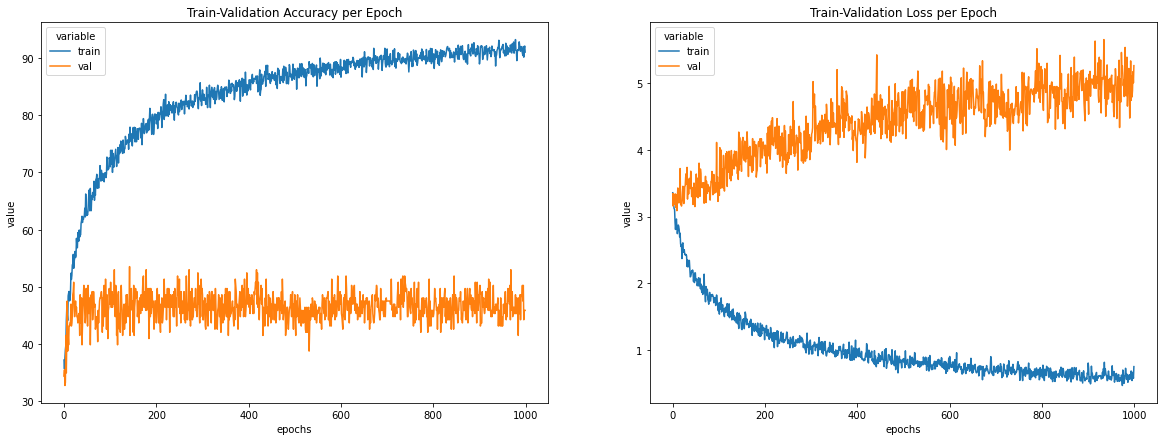

In [27]:
np.random.seed(seed)

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Validation Accuracy per Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Validation Loss per Epoch')

In [28]:
np.random.seed(seed)

y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

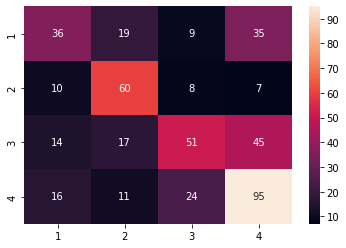

In [29]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [30]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.47      0.36      0.41        99
         1.0       0.56      0.71      0.62        85
         2.0       0.55      0.40      0.47       127
         3.0       0.52      0.65      0.58       146

    accuracy                           0.53       457
   macro avg       0.53      0.53      0.52       457
weighted avg       0.53      0.53      0.52       457



In [31]:
gain_matrix = np.array([[  5, -5, -5,  2],
                        [ -5, 10,  2, -5],
                        [ -5,  2, 10, -5],
                        [  2, -5, -2,  5]])
print(gain_matrix)

confusion_matrix = confusion_matrix_df.to_numpy()
print(confusion_matrix)

estimated_revenues = 0
revenue_matrix = np.zeros((4,4))
for row_index, row in enumerate(gain_matrix):
    for index, cell in enumerate(row):
        cur_cost = cell * confusion_matrix[row_index][index]
        estimated_revenues += cur_cost
        revenue_matrix[row_index][index] += cur_cost
print(revenue_matrix)
print(estimated_revenues)

[[ 5 -5 -5  2]
 [-5 10  2 -5]
 [-5  2 10 -5]
 [ 2 -5 -2  5]]
[[36 19  9 35]
 [10 60  8  7]
 [14 17 51 45]
 [16 11 24 95]]
[[ 180.  -95.  -45.   70.]
 [ -50.  600.   16.  -35.]
 [ -70.   34.  510. -225.]
 [  32.  -55.  -48.  475.]]
1294


In [32]:
def profit(confusion):
    cost = np.array([
        [5., -5., -5., 2.],
        [-5., 10., 2., -5.],
        [-5., 2., 10., -5.],
        [2., -5., -2., 5.]
    ])
    
    return (confusion * cost).sum()

print(profit(confusion_matrix))

1294.0


[Text(0.5, 1.0, 'Confusion Matrix on Test Set')]

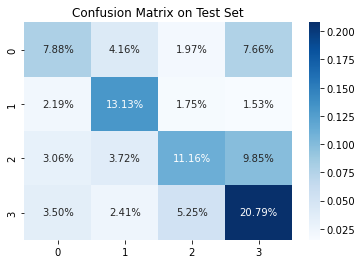

In [33]:
sns.heatmap(
    confusion_matrix/confusion_matrix.sum(), 
    annot=True, 
    fmt='.2%', 
    cmap='Blues'
).set(title="Confusion Matrix on Test Set")

[Text(0.5, 1.0, 'Confusion Matrix on test set (profit)')]

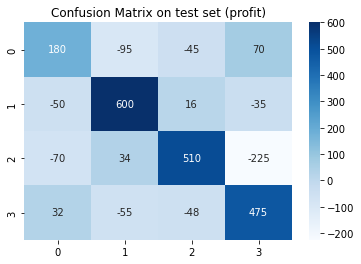

In [34]:
sns.heatmap(
    revenue_matrix.astype(int), 
    annot=True, 
    fmt='d', 
    cmap='Blues'
).set(title="Confusion Matrix on test set (profit)")